# Importing packages

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/cardiac-amyloidosis/026_SVM_mistic2


In [2]:
import sys
# sys.path.append('/Users/c.kieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
import pickle

In [4]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [5]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "Mistic2_paramsOnly" #what data did you put in
fileName_common = "_linear" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_241118_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "Mistic2_paramsOnly_linear_", folderName_common= "241118_", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [6]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [7]:
#parameters of SVM 
red_factor = 0.05

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

C_range = [2**x for x in range(-2,5)]
# gamma_range = [2**x for x in range(-9,1)]


kernel_type = "linear"

rank_weights = [0,0.25,0.50,0.75,1]

# importing our data

In [8]:
dataFileName = "AL-KnownPts_CompLabswoEcho_paramsOnly_MDfits_1Sheet_20241018_v1.xlsx"

In [9]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

# Setting up classifier

## Scaling data and defining test set

In [10]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]


#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

In [11]:
X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

## define cross validation

In [12]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [13]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-12)


parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

# feature selection

In [14]:

svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 329, Score: 0.732
Number of Features: 312, Score: 0.670
Number of Features: 296, Score: 0.596
Number of Features: 281, Score: 0.615
Number of Features: 266, Score: 0.608
Number of Features: 252, Score: 0.619
Number of Features: 239, Score: 0.567
Number of Features: 227, Score: 0.563
Number of Features: 215, Score: 0.553
Number of Features: 204, Score: 0.529
Number of Features: 193, Score: 0.583
Number of Features: 183, Score: 0.563
Number of Features: 173, Score: 0.541
Number of Features: 164, Score: 0.574
Number of Features: 155, Score: 0.547
Number of Features: 147, Score: 0.570
Number of Features: 139, Score: 0.519
Number of Features: 132, Score: 0.590
Number of Features: 125, Score: 0.572
Number of Features: 118, Score: 0.550
Number of Features: 112, Score: 0.529
Number of Features: 106, Score: 0.612
Number of Features: 100, Score: 0.562
Number of Features: 94, Score: 0.558
Number of Features: 89, Score: 0.558
Number of Features: 84, Score: 0.5

In [15]:
# # add pickling stage here so that you can use this data for easy replotting

# #if not already pickled use this block
# pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'wb')
# pickle.dump(svm_set_ranks, pickle_file)



# Performance plots

## F1 and AUC plots

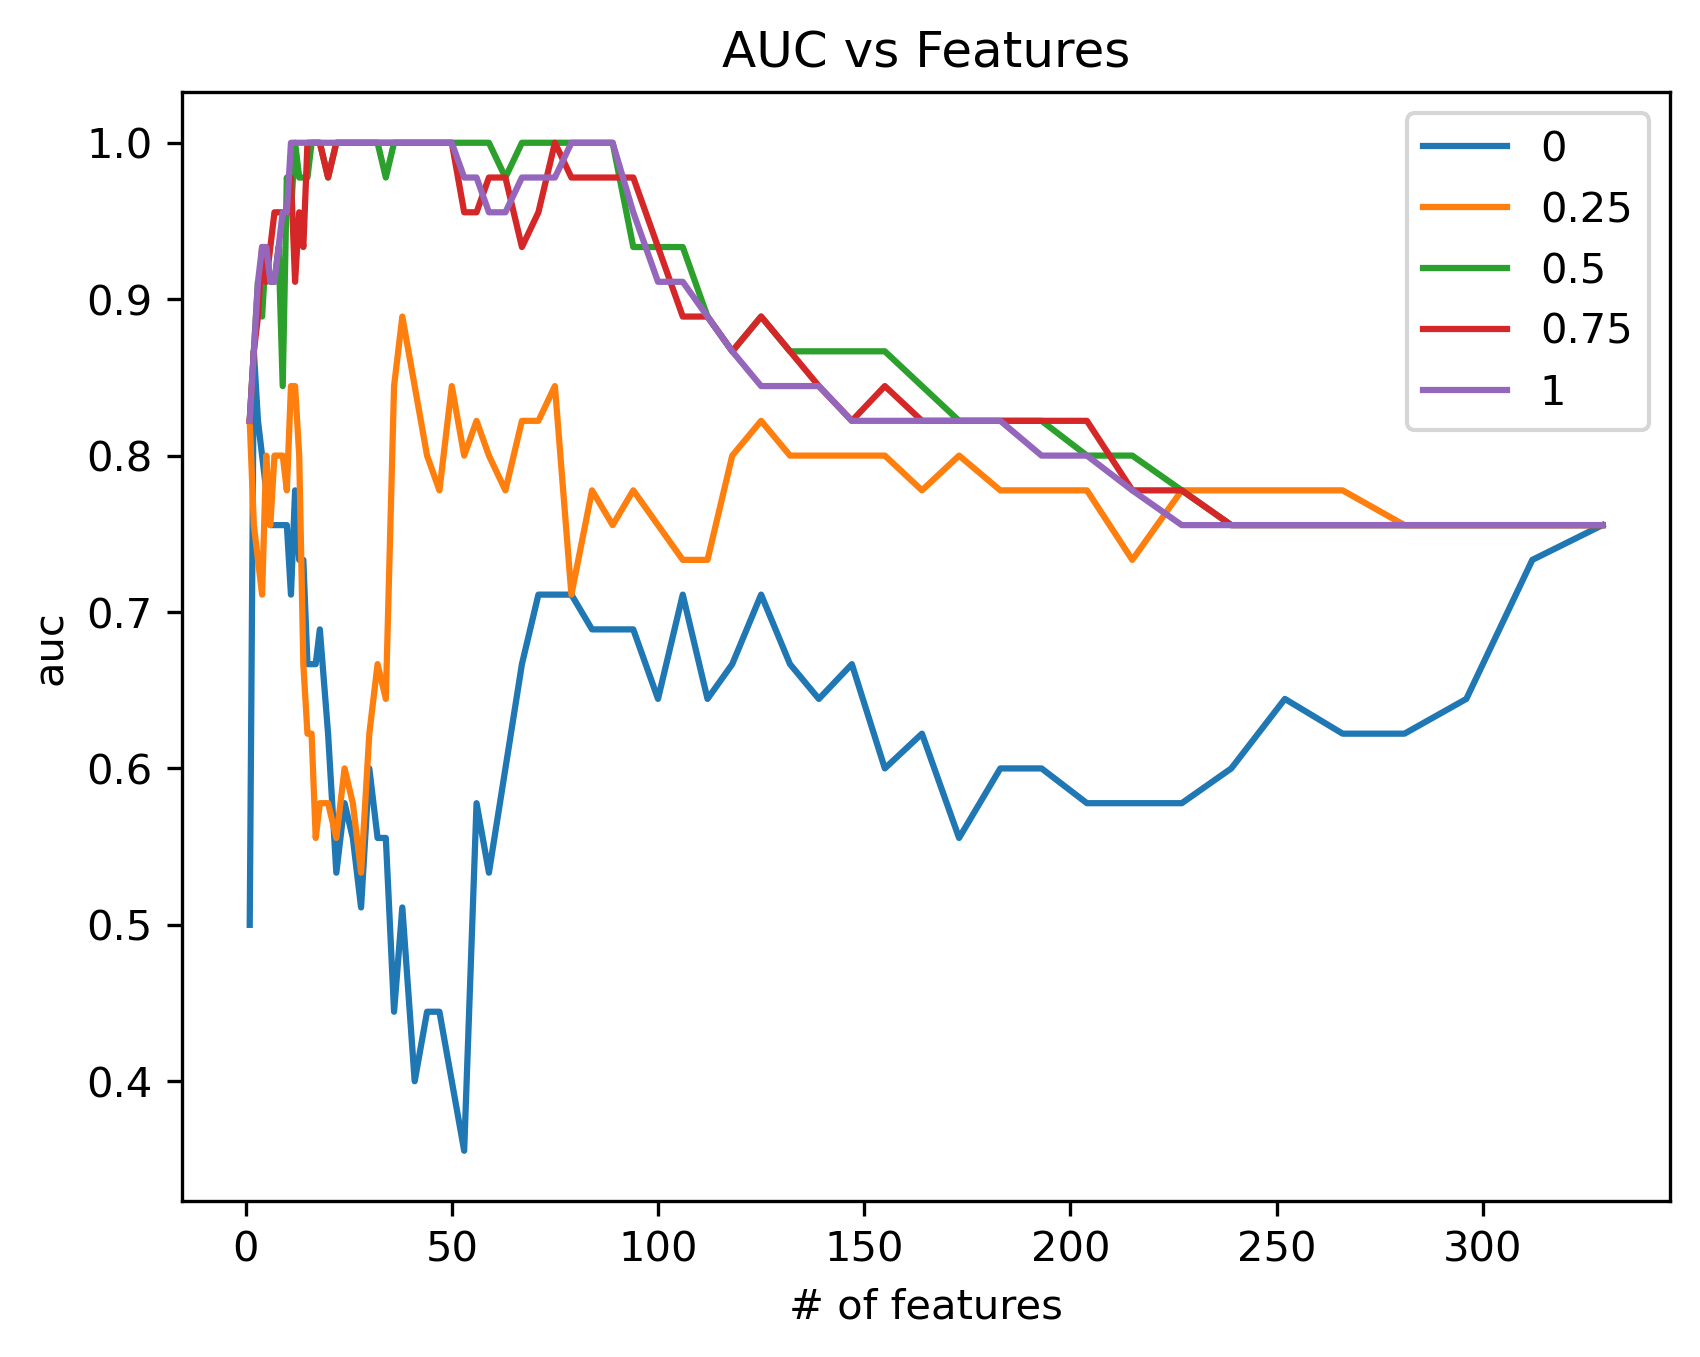

In [16]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

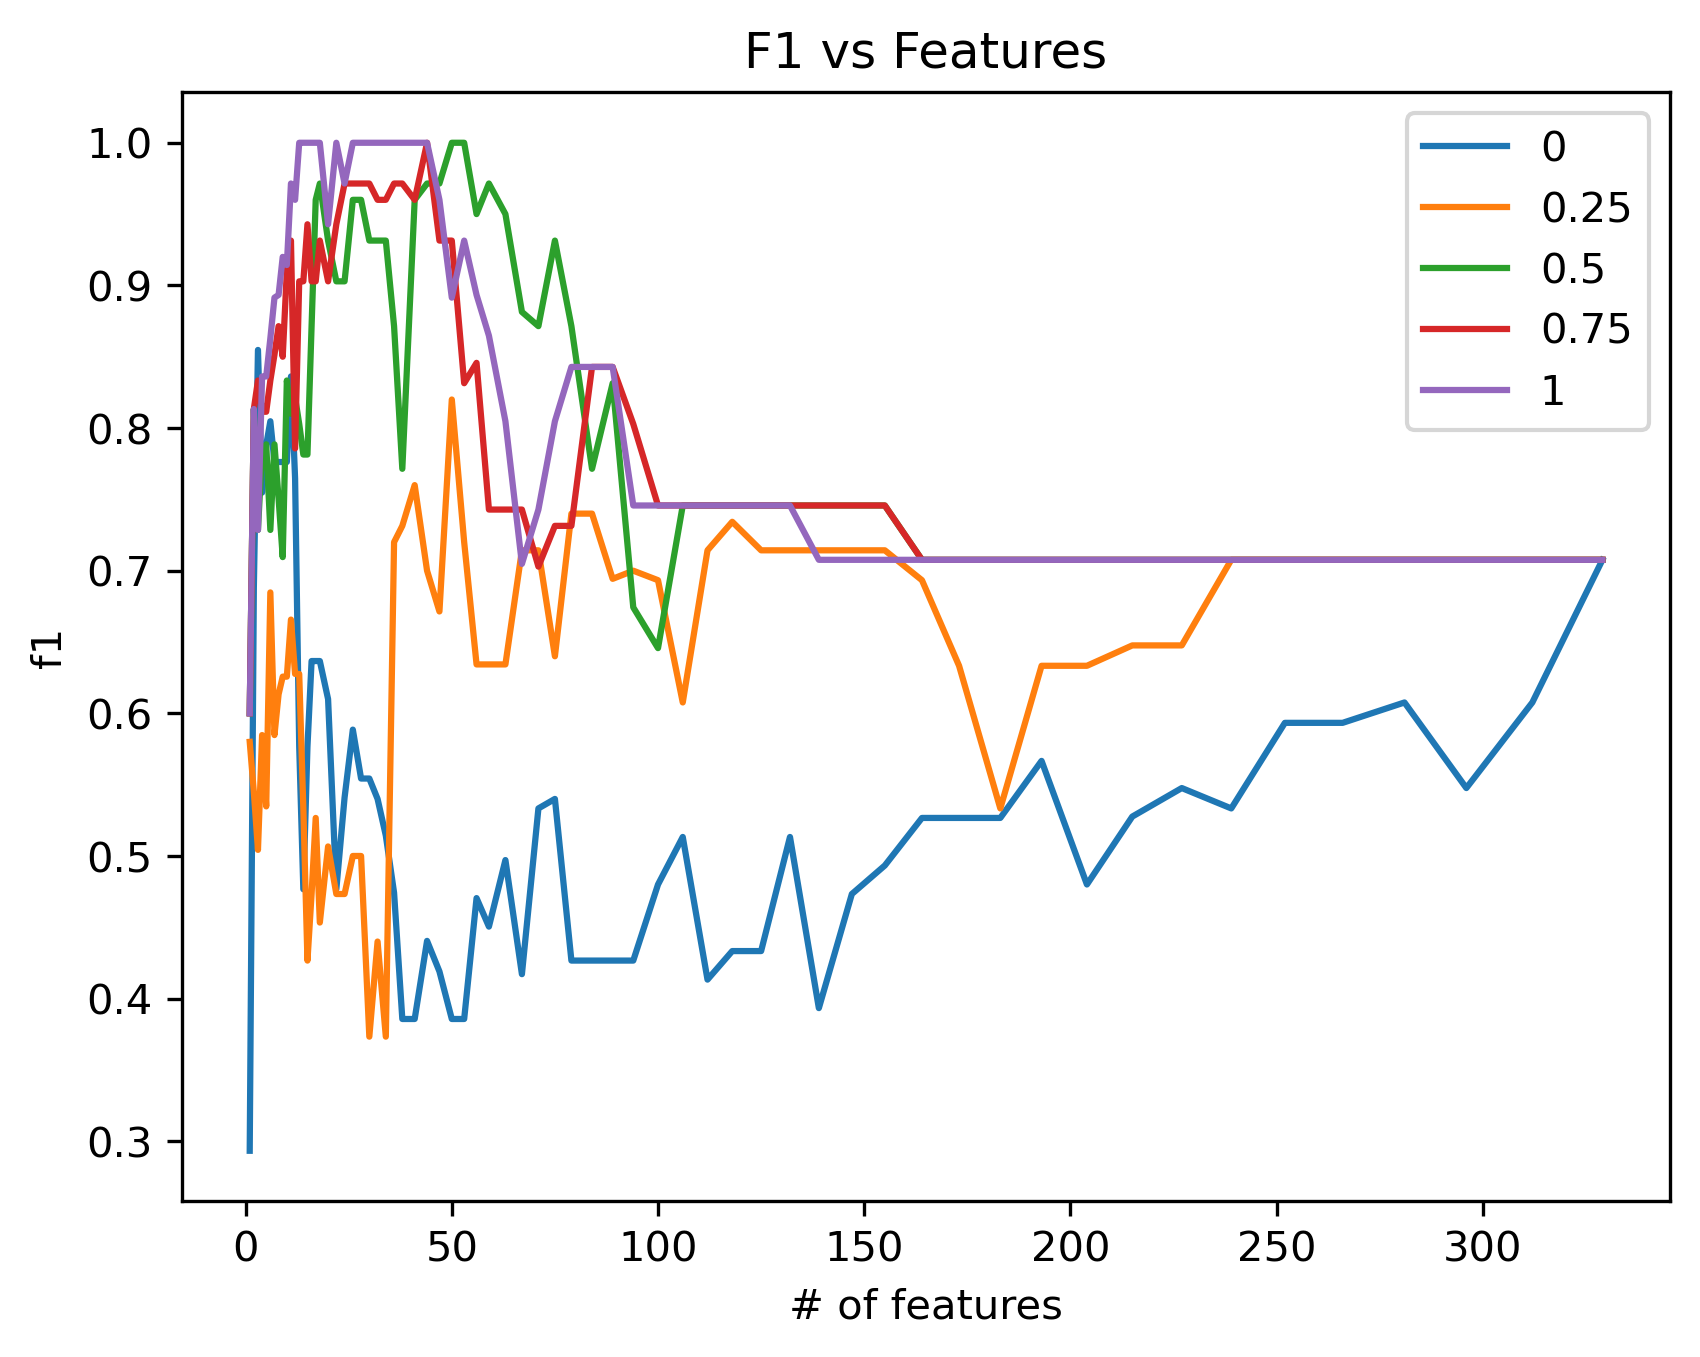

In [17]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

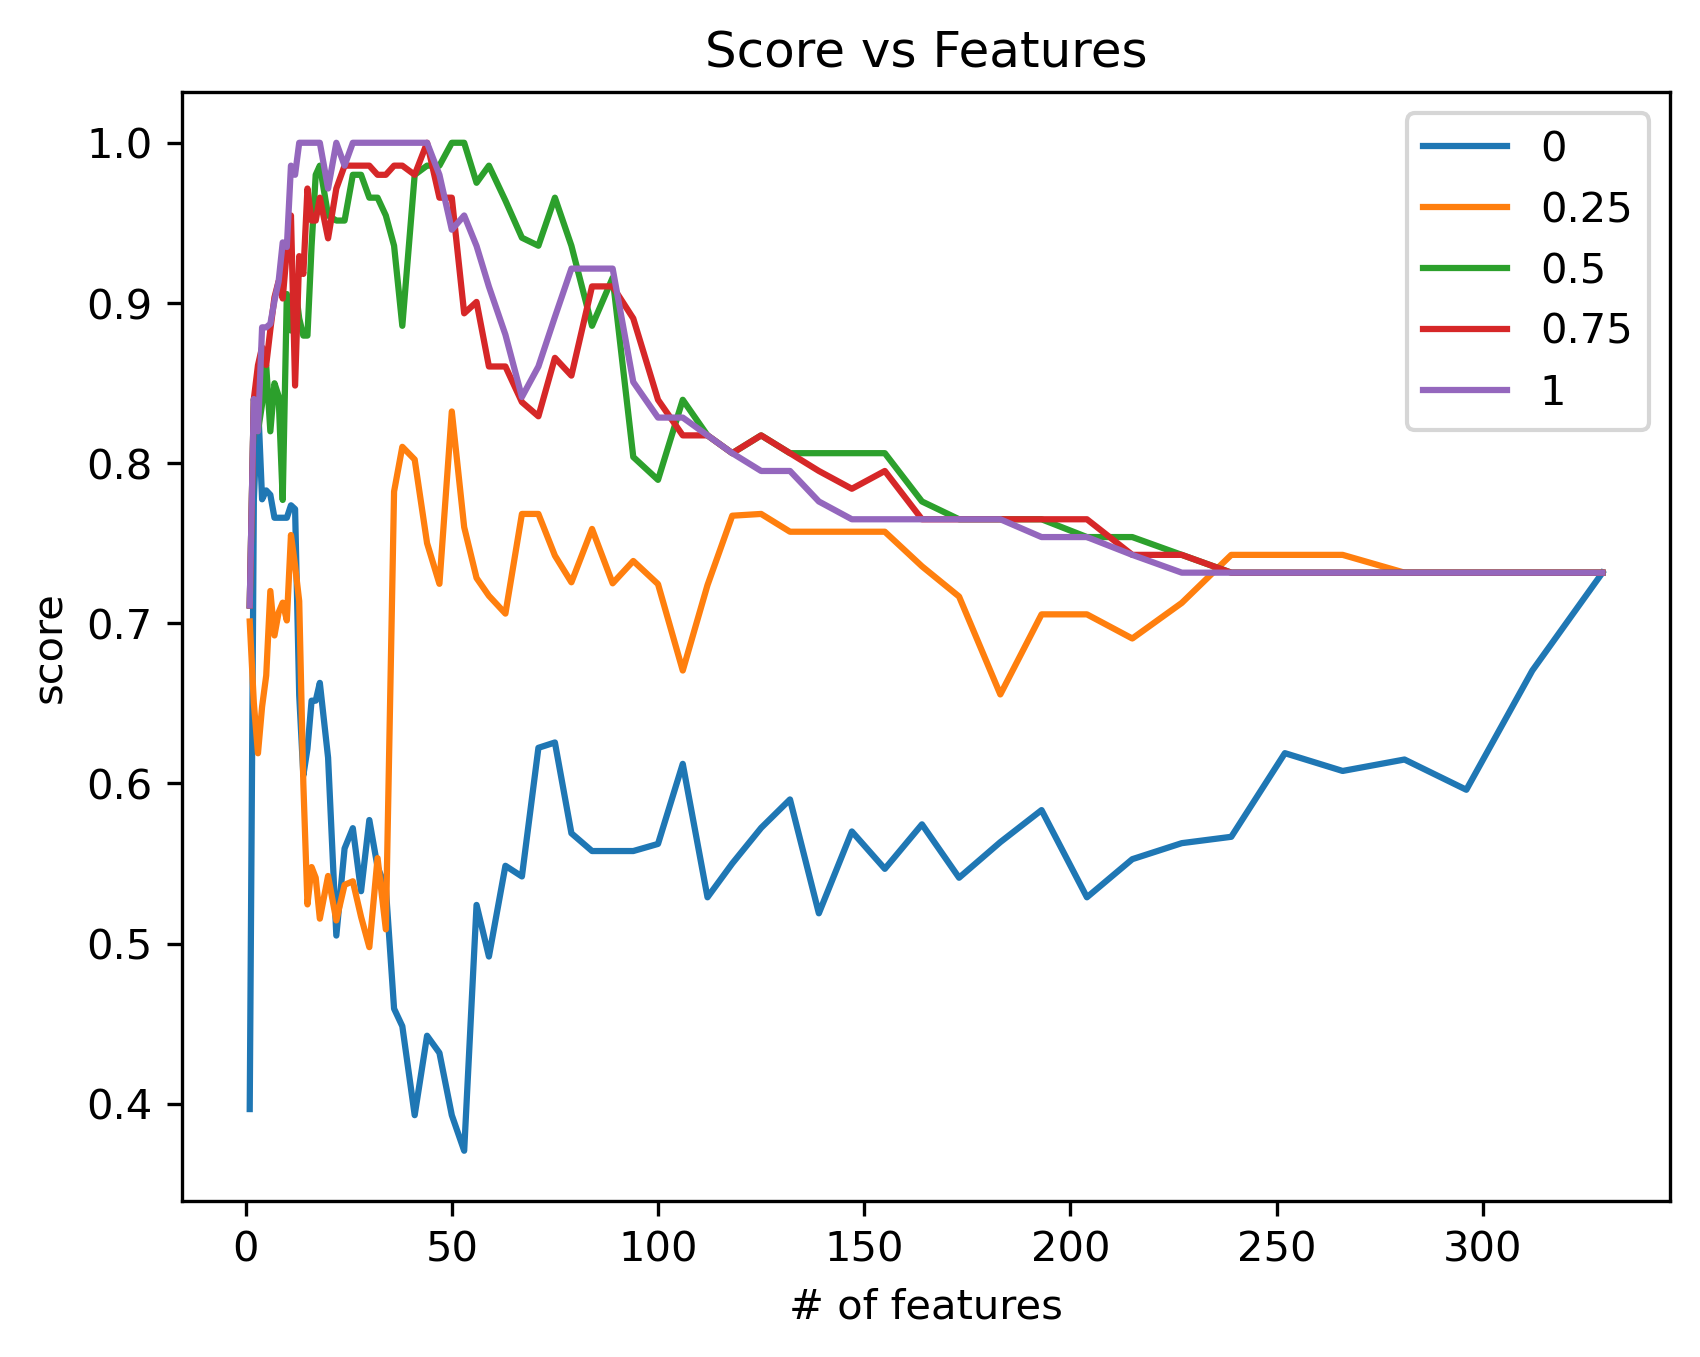

In [18]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [19]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score())

# selected_run = 4 
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.5770066821054664,
 0.7159067882472139,
 0.8085053312104985,
 0.8032988372654027,
 0.8055343272060598]

In [20]:
svm_set_ranks[selected_run].performance_

{'f1': 1.0,
 'auc': 1.0,
 'score': 1.0,
 'C': 0.25,
 'num_features': 50,
 'mean_nSV': 19.2}

In [21]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [22]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [23]:
# #collecting the performance as a dataframe
# df_bestPerformance = pd.DataFrame(svm_set_ranks[topModelIndex].performance_)
# outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(rank_weights[topModelIndex]) + "_best model perf")


# df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[topModelIndex].features]))
# #saving the best features
# outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(rank_weights[topModelIndex]) + "_features")



In [24]:
# for i in range(len(rank_weights)): 
#     # print("test")
#     print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
#     print("features: ", "\n", list(X.columns[svm_set_ranks[i].features]), "\n")

In [25]:
# X.columns[svm_set_ranks[3].features]

In [26]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [27]:
df_performance

f1       auc     score     C  num_features  mean_nSV
0     0.854762  0.822222  0.838492  4.00           3.0      25.2
0.25  0.820000  0.844444  0.832222  0.25          50.0      20.0
0.5   1.000000  1.000000  1.000000  0.25          50.0      19.2
0.75  1.000000  1.000000  1.000000  0.25          44.0      19.8
1     1.000000  1.000000  1.000000  0.25          13.0      12.2

In [28]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.400000  0.80       5.0        0.0        3.0       1.0   
0.25  0.333333  0.45       4.0        1.0        3.0       1.0   
0.5   0.750000  0.95       4.0        1.0        1.0       3.0   
0.75  0.750000  0.95       4.0        1.0        1.0       3.0   
1     0.666667  0.95       5.0        0.0        2.0       2.0   

      precision or PPV  recall or TPR  specificity or TNR  
0                 1.00           0.25                 1.0  
0.25              0.50           0.25                 0.8  
0.5               0.75           0.75                 0.8  
0.75              0.75           0.75                 0.8  
1                 1.00           0.50                 1.0

In [29]:
df_features

0  \
0                                     Age   
1   Platelet Count Result(k/uL) Linear R2   
2               MCHC Result Exp intercpet   
3                                     NaN   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                                     NaN   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                                    NaN   
13                                    NaN   
14                                    NaN   
15                                    NaN   
16                                    NaN   
17                                    NaN   
18                                    NaN   
19                                    NaN   
20                                    NaN   
21                                    NaN   
22                                    NaN   
23                                    NaN   
24                                    NaN   
25                                    NaN   
26                                    NaN   
27                                    NaN   
28                                    NaN   
29                                    NaN   
30                                    NaN   
31                                    NaN   
32                                    NaN   
33                                    NaN   
34                                    NaN   
35                                    NaN   
36                                    NaN   
37                                    NaN   
38                                    NaN   
39                                    NaN   
40                                    NaN   
41                                    NaN   
42                                    NaN   
43                                    NaN   
44                                    NaN   
45                                    NaN   
46                                    NaN   
47                                    NaN   
48                                    NaN   
49                                    NaN   

                                                 0.25  \
0                                                 Age   
1                         ALT Result(U/L) Linear coef   
2                         BUN Result(mg/dL) Linear R2   
3                   Calcium Result(mg/dL) Linear coef   
4                  Hemoglobin Result Linear intercept   
5                           LDH Result(U/L) Linear R2   
6                        MCHC Result Linear intercept   
7                    MCV Result Linear residual error   
8                           Monocyte Result Linear R2   
9                       Neutrophil Result Linear coef   
10                 Neutrophil Result Linear intercept   
11                     Nucleated RBC Result Linear R2   
12                   Pct. Neutrophil Result Linear R2   
13       Platelet Count Result(k/uL) Linear intercept   
14       Serum Electrophoresis Gamma Result Linear R2   
15             Sodium Result(mmol/L) Linear intercept   
16             Total Serum Protein Result Linear coef   
17        Total Serum Protein Result Linear intercept   
18   Total Serum Protein Result Linear residual error   
19                       WBC Result(k/uL) Linear coef   
20                  WBC Result(k/uL) Linear intercept   
21  NT Pro BNP (B-Type Natriuretic Peptide) Linear...   
22  NT Pro BNP (B-Type Natriuretic Peptide) Linear...   
23                 ALT Result(U/L) Exp residual error   
24            Albumin Electrophoresis Result Exp coef   
25                           BUN Result(mg/dL) Exp R2   
26                     Calcium Result(mg/dL) Exp coef   
27                Calcium Result(mg/dL) Exp intercpet   
28       Kappa Free Light Chains Result (mg/L) Exp R2   
29                             LDH

# plots for best model

## pair plots

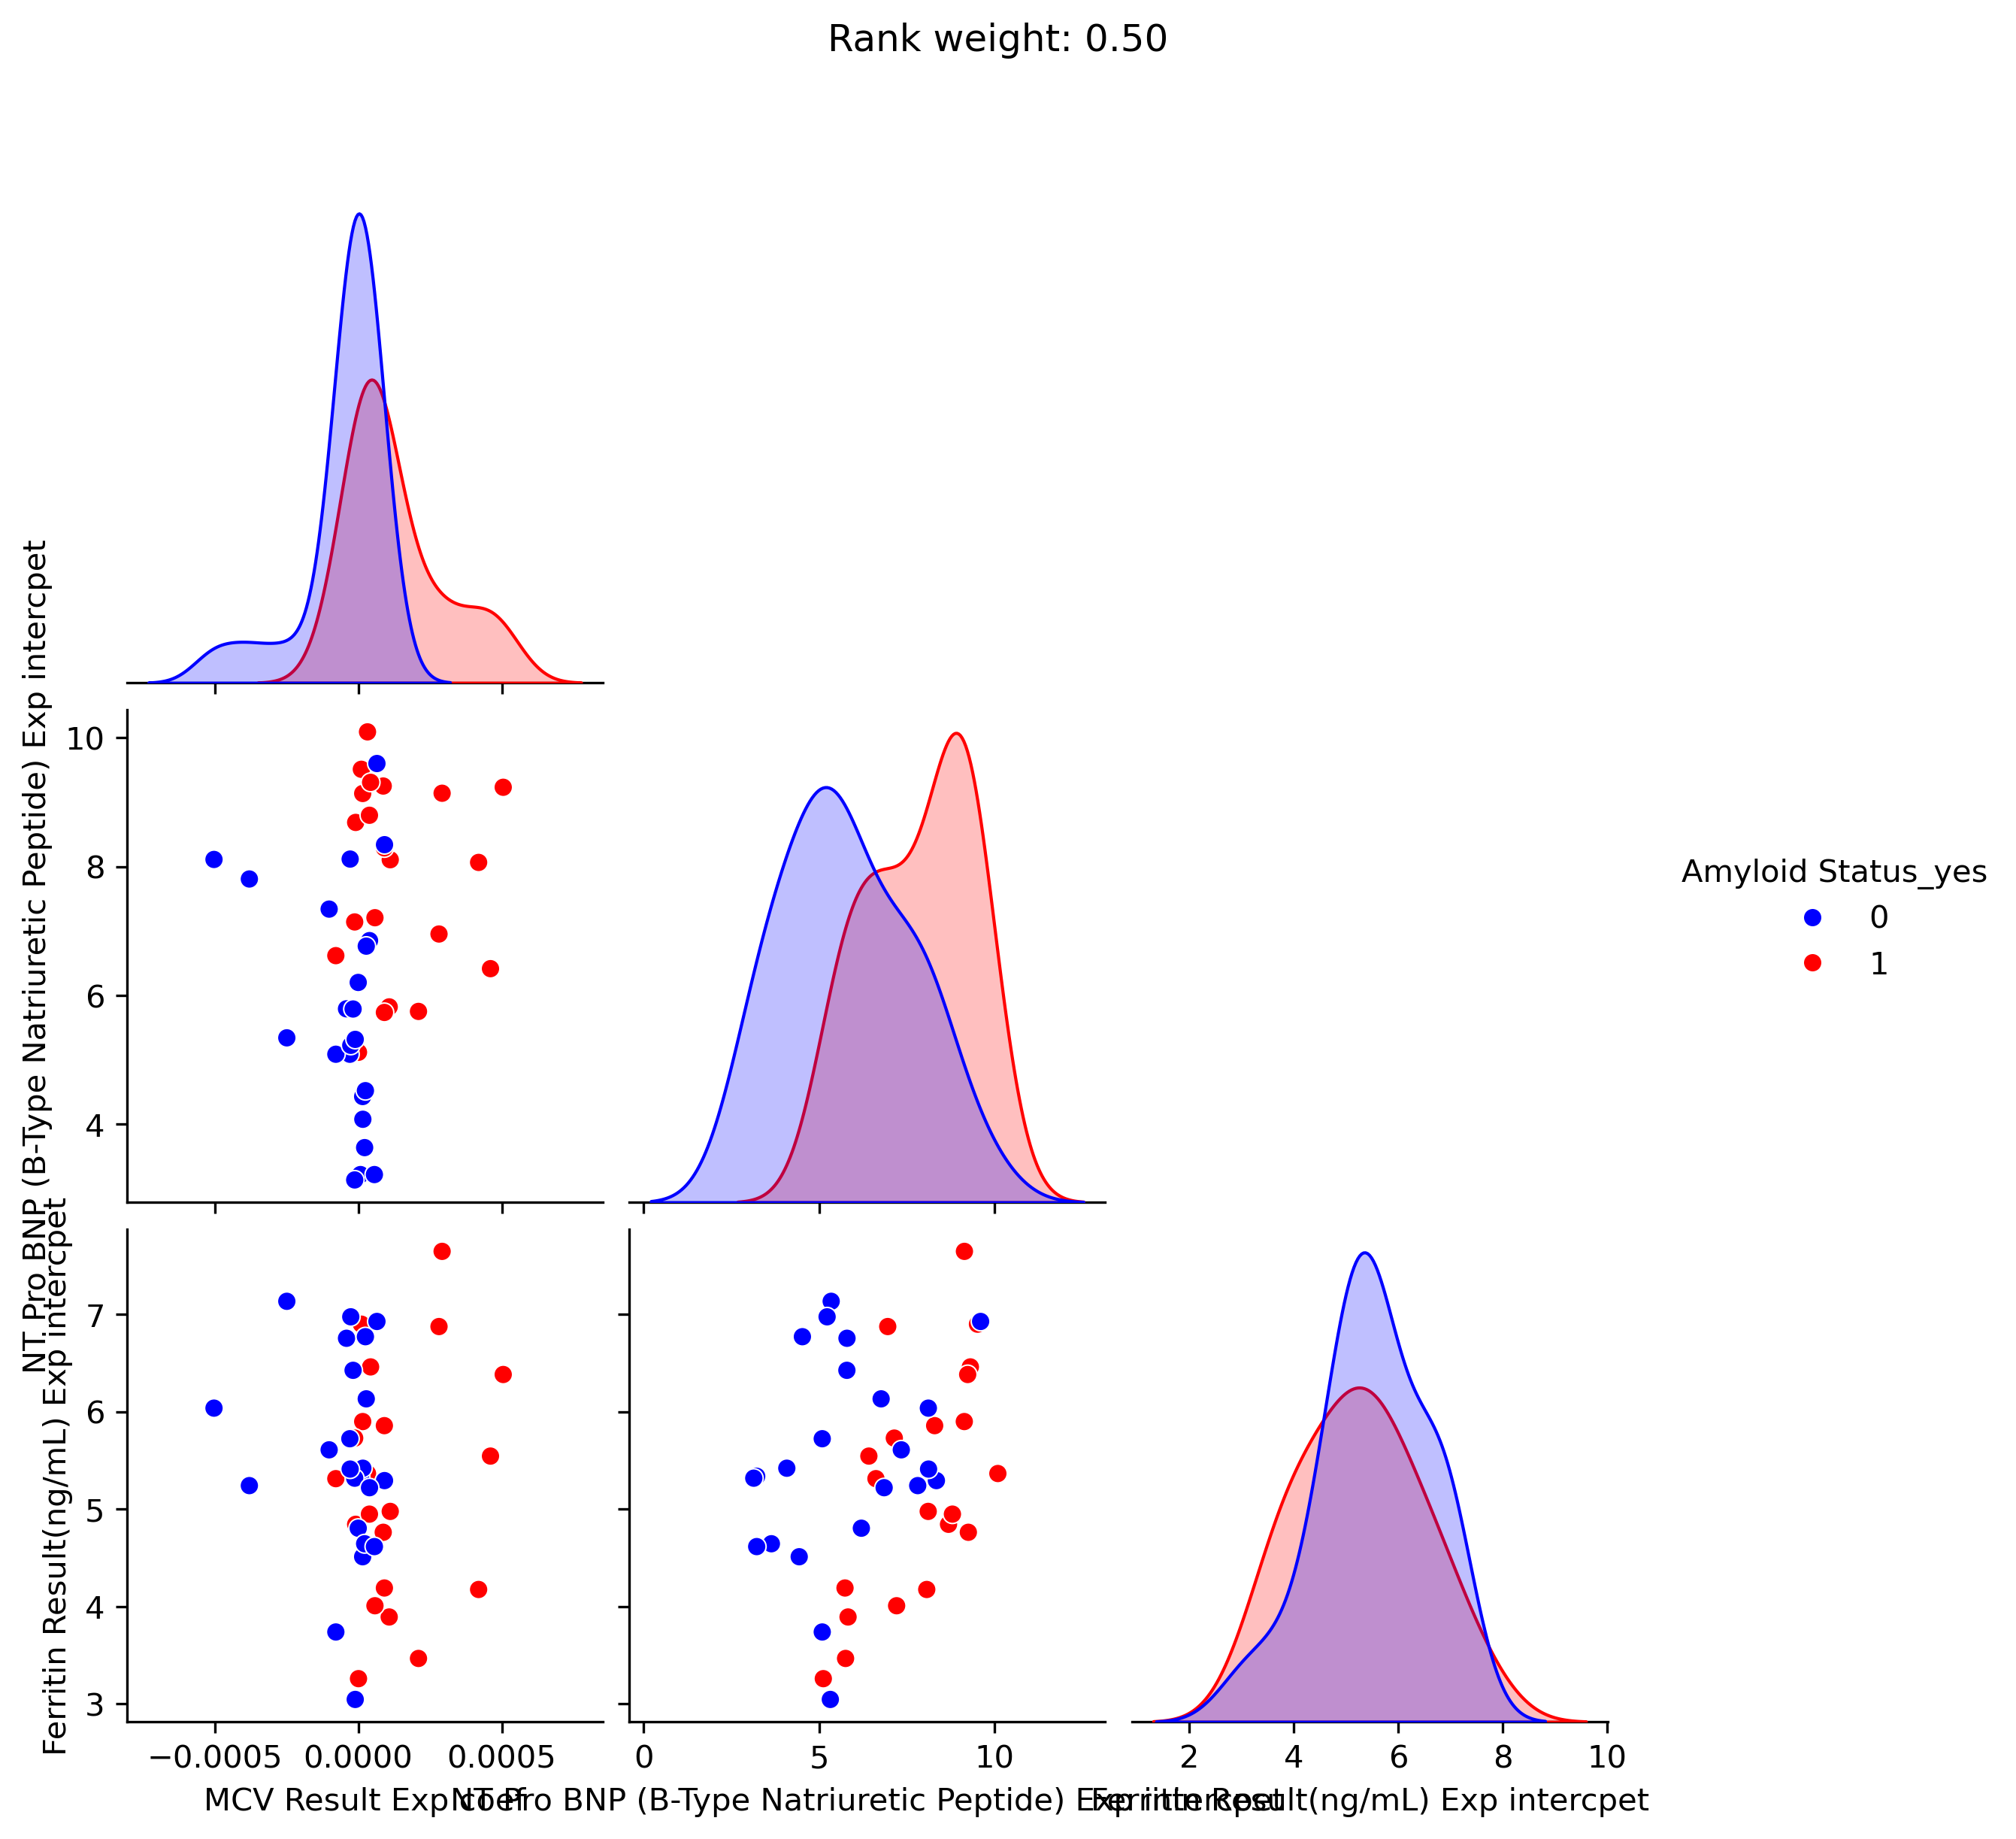

In [30]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[0:3]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

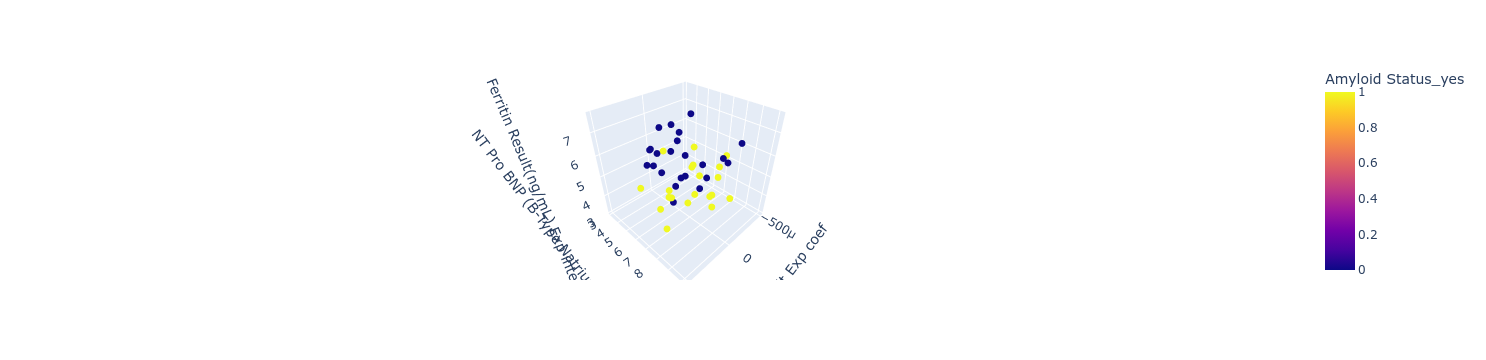

In [31]:
fig = px.scatter_3d(dataTable, x=top_features[0], y=top_features[1], z=top_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



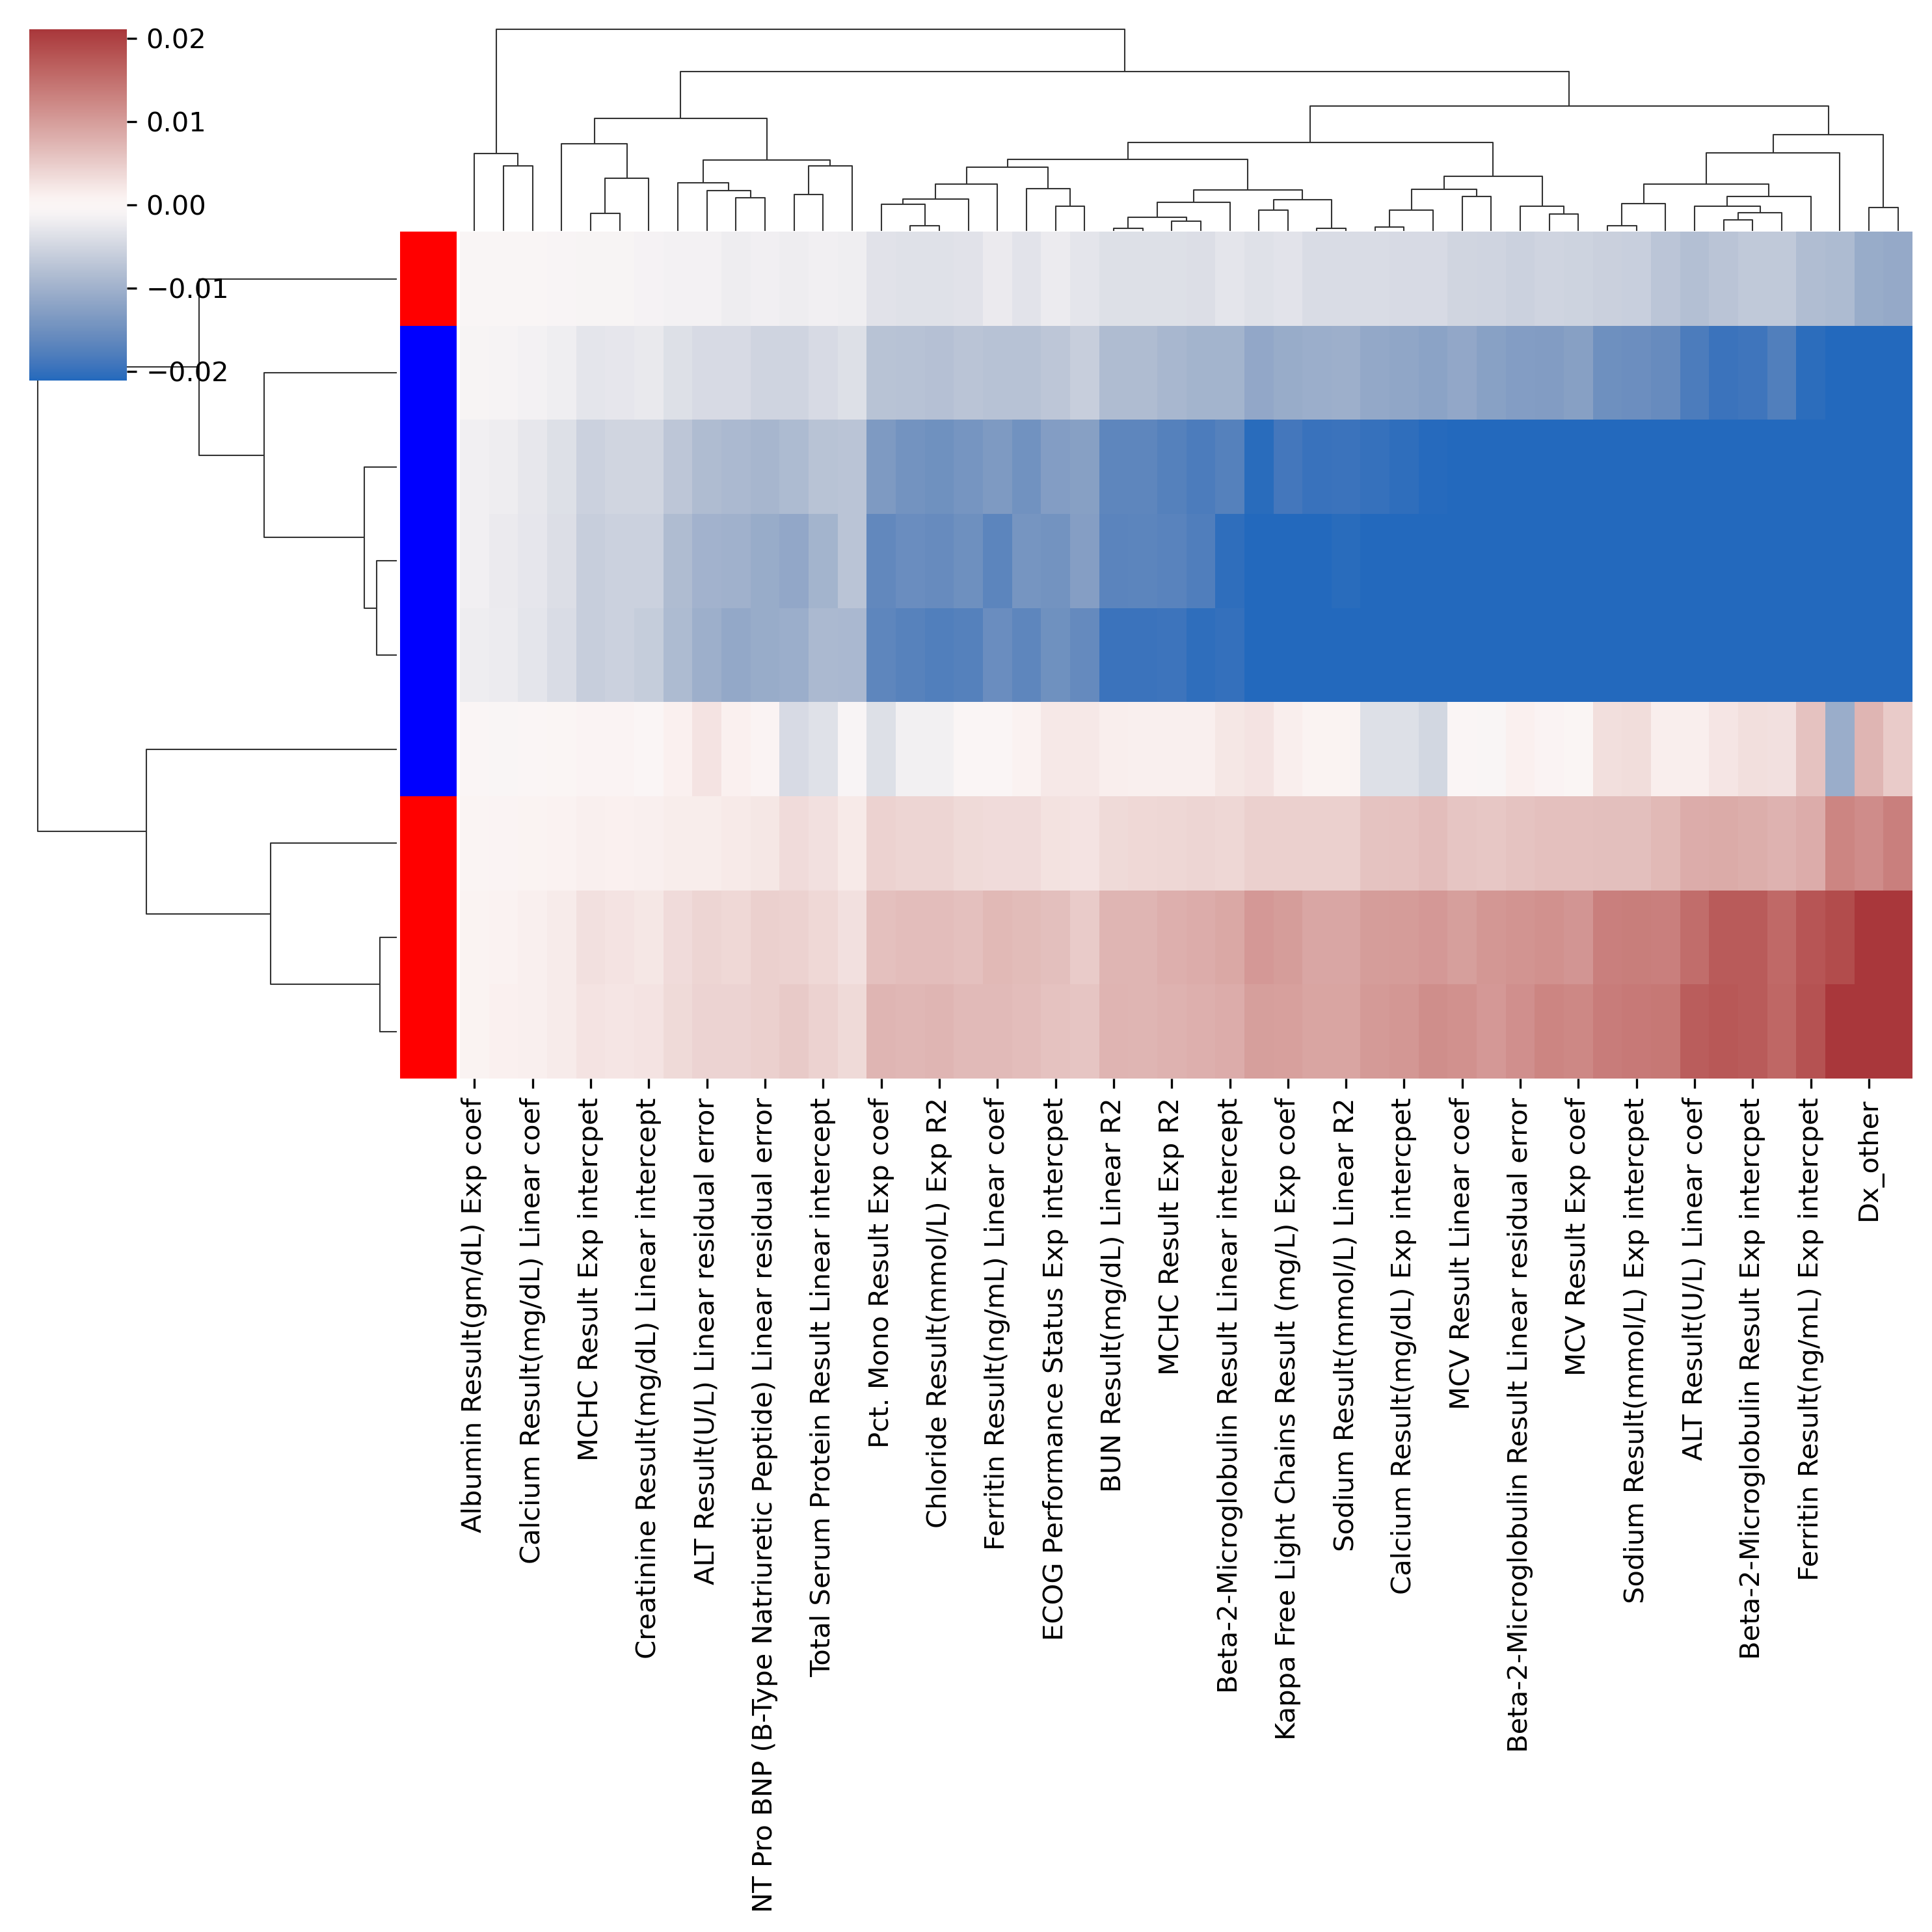

In [32]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_test)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_IGheatmap"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

In [33]:
# from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

# linkMeth = "average"

# IG = svm_set_ranks[selected_run].integrated_gradient(X_all)

# IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

# distMatCol = perDiff(IGtable)
# hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

# tr_IGtable = IGtable.transpose()
# distMatRow = perDiff(tr_IGtable)
# hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

# color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

# #fig, ax = plt.subplots()
# fig = clustermap(IGtable, 
#            yticklabels=False,
#            cmap="vlag", vmin=-color_val, vmax=color_val,
#            row_linkage=hcRow, col_linkage=hcCol, 
#            row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_Xall_IGheatmap"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')

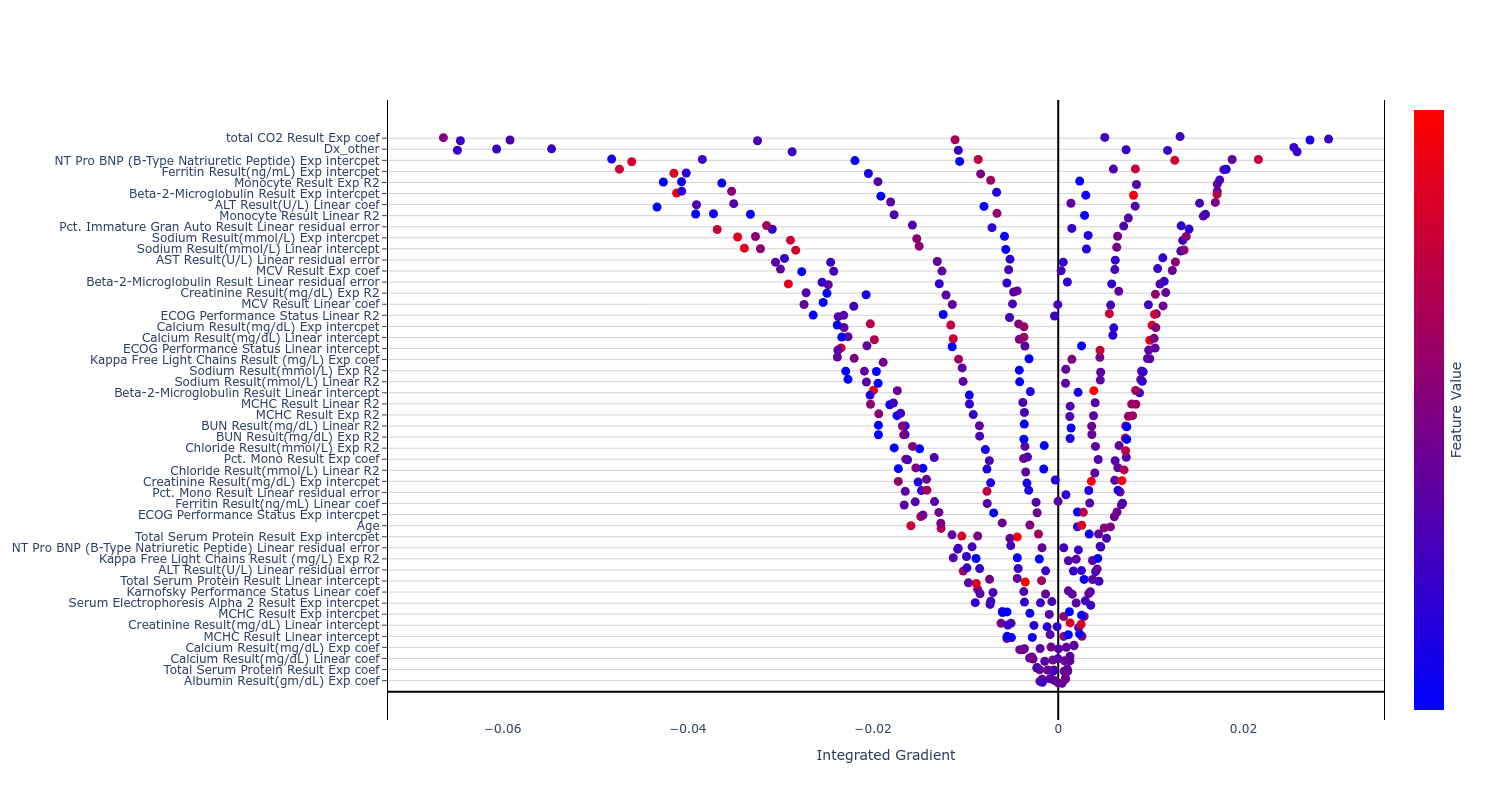

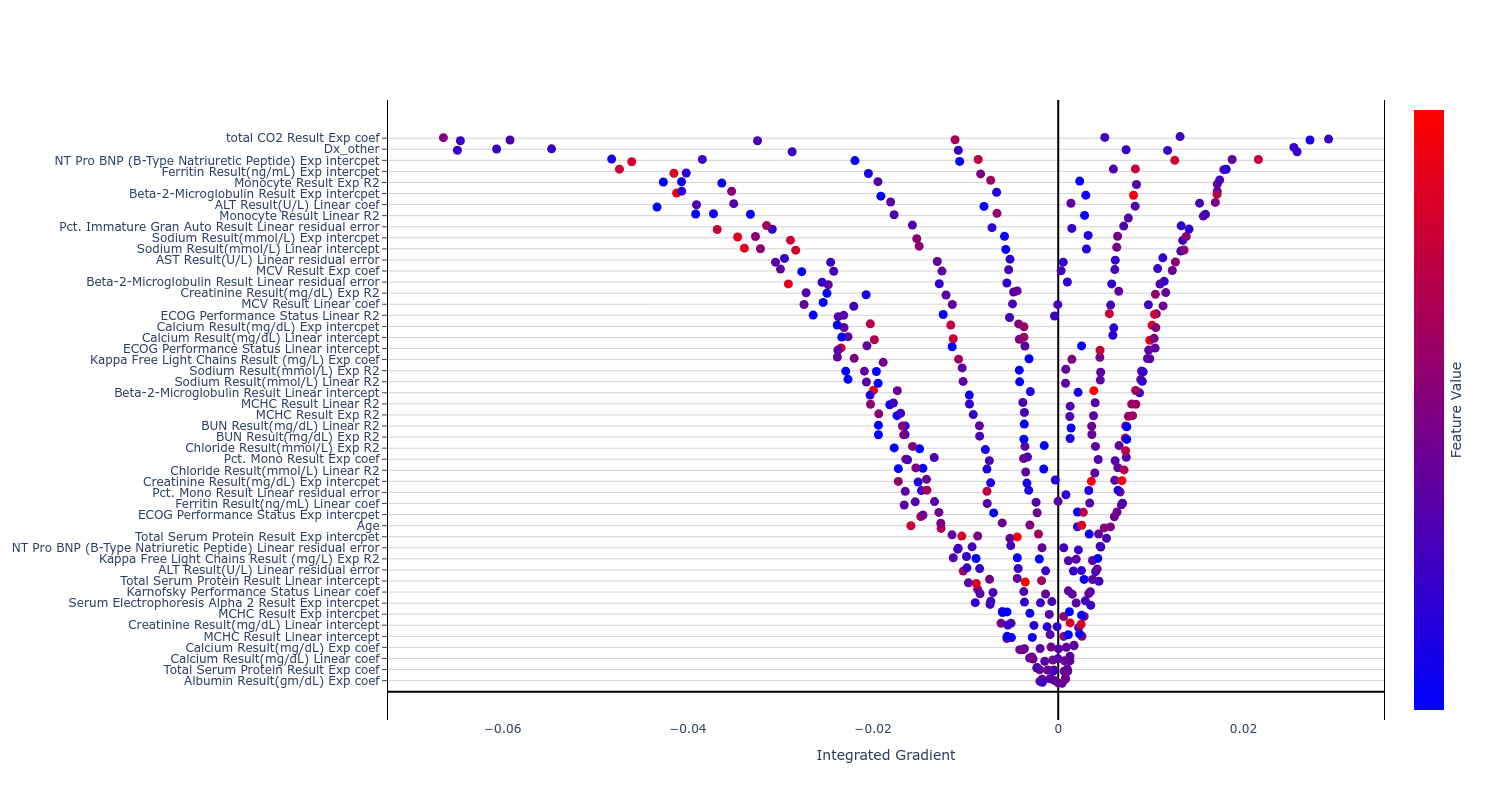

In [34]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_test = pd.DataFrame(X_test[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_test.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
fig.show()

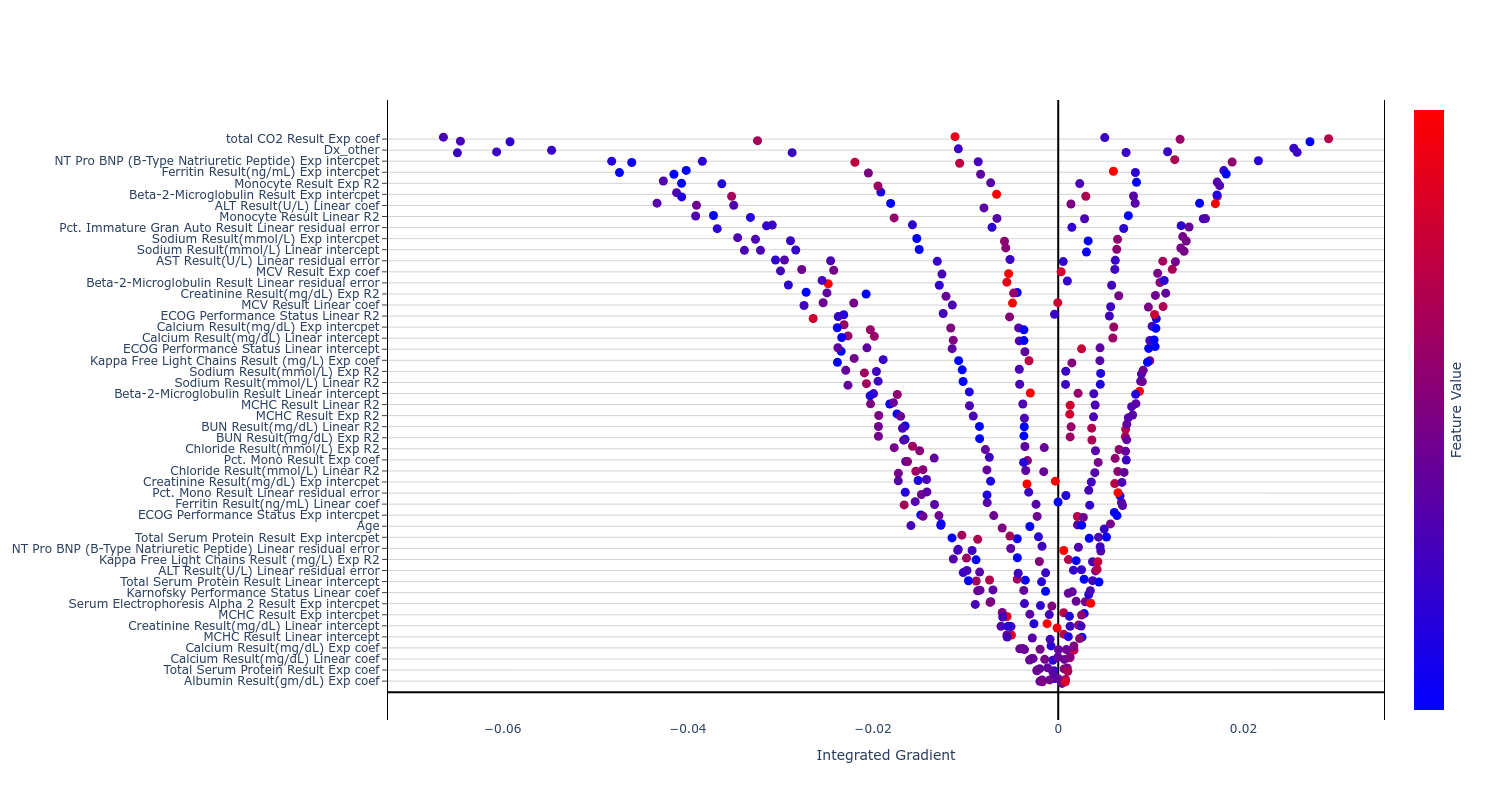

In [35]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_all = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_all.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_Xall_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
#fig.show()

## 2x2

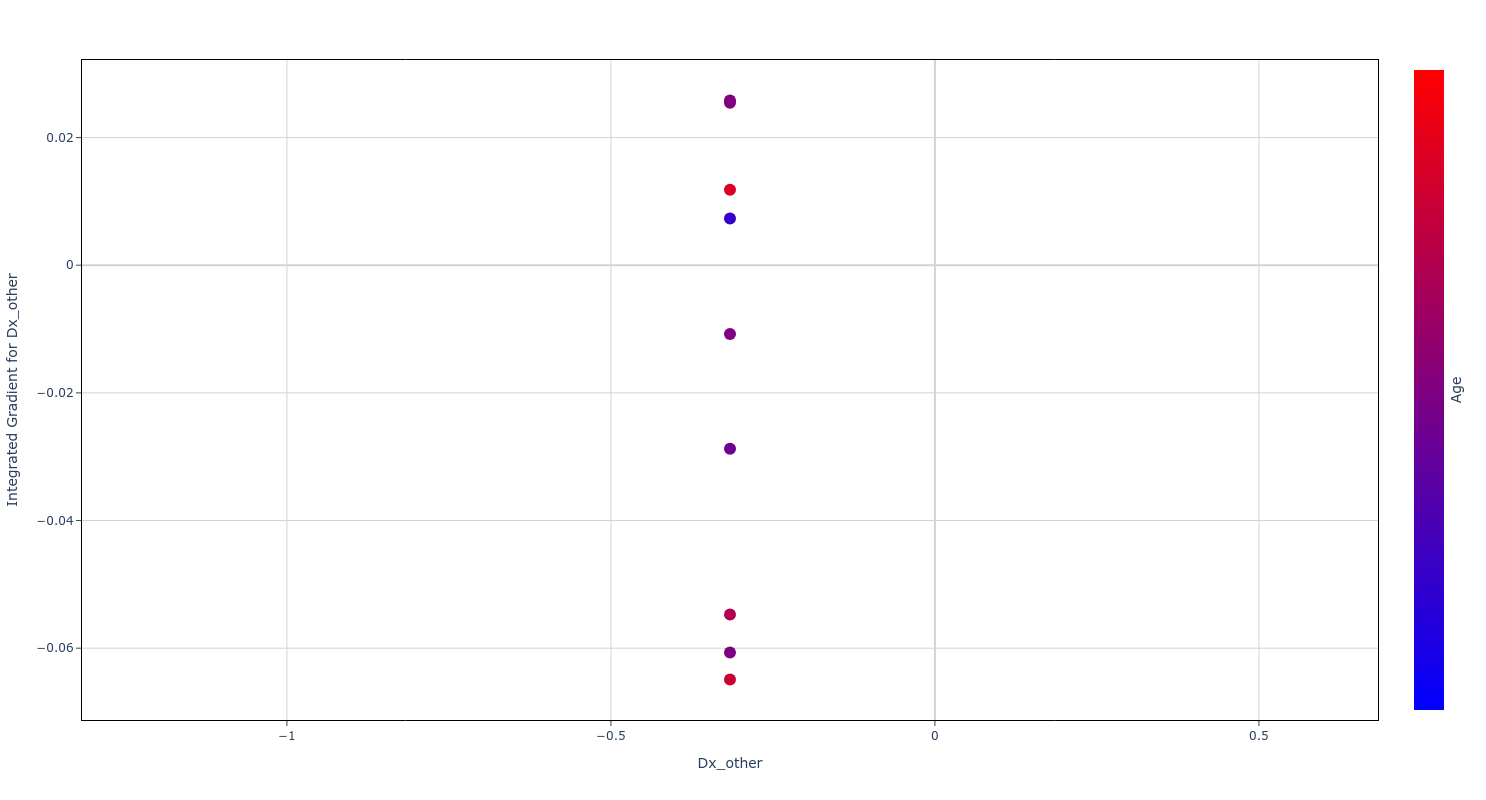

AttributeError: 'Figure' object has no attribute 'savefig'

In [36]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_test[feat_1], y = IGtable[feat_1], color = df_X_test[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

In [37]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_all[feat_1], y = IGtable[feat_1], color = df_X_all[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_Xall_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 9, whereas the length of  previously-processed arguments ['x'] is 44